In [13]:
from ultralytics import YOLO
from deepface import DeepFace
import cv2
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os

In [2]:
import torch
print("GPU détecté" if torch.cuda.is_available() else "Pas de GPU détecté")
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

GPU détecté


## Testing different face recognition models

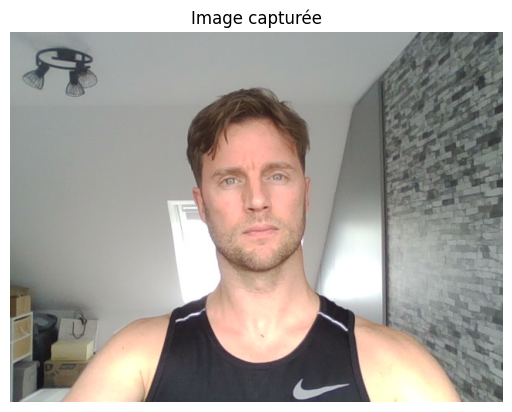

Test avec modèle : VGG-Face
Reconnu par VGG-Face → C:\Users\nico_\Desktop\Reconnaissance faciale\img_real\nico_face.jpg (distance = 0.2577)

Test avec modèle : Facenet
Reconnu par Facenet → C:\Users\nico_\Desktop\Reconnaissance faciale\img_real\nico_face.jpg (distance = 0.1299)

Test avec modèle : ArcFace
Reconnu par ArcFace → C:\Users\nico_\Desktop\Reconnaissance faciale\img_real\nico_face.jpg (distance = 0.2616)

Test avec modèle : Facenet512
Reconnu par Facenet512 → C:\Users\nico_\Desktop\Reconnaissance faciale\img_real\nico_face.jpg (distance = 0.1611)

Test avec modèle : SFace
Reconnu par SFace → C:\Users\nico_\Desktop\Reconnaissance faciale\img_real\nico_face.jpg (distance = 0.3911)



In [12]:
# Capture depuis la webcam
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

# Sauvegarde
cv2.imwrite("temp_webcam.jpg", frame)

# Affichage dans le notebook
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.axis("off")
plt.title("Image capturée")
plt.show()

# Liste des modèles à tester
models = ["VGG-Face", "Facenet", "ArcFace", "Facenet512", "SFace"]
db_path = r"C:\Users\nico_\Desktop\Reconnaissance faciale\img_real"

# Test pour chaque modèle
for model in models:
    print(f"Test avec modèle : {model}")
    try:
        df = DeepFace.find(
            img_path="temp_webcam.jpg",
            db_path=db_path,
            enforce_detection=False,
            silent=True,
            model_name=model,
            detector_backend="retinaface"  # meilleur pour angles
        )
        df = df[0]
        if not df.empty:
            identity = df.iloc[0]["identity"]
            distance = df.iloc[0]["distance"]
            print(f"Reconnu par {model} → {identity} (distance = {distance:.4f})\n")
        else:
            print(f"Pas de correspondance trouvée avec {model}\n")
    except Exception as e:
        print(f"Erreur avec {model} : {e}\n")


Avec une distance de 0.1299, le modèle Facenet est celui qui reconnaît le mieux mon visage

## Uploading YOLO8 model

In [15]:
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 38.4MB/s]


In [21]:
# Utilisation du gpu
model.to("cuda") 

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

In [16]:
# Dossier avec images faciales 
db_path = r"C:\Users\nico_\Desktop\Reconnaissance faciale\img_real"

In [17]:
# Modèle DeepFace à utiliser
deepface_model = "Facenet"

In [19]:
# Ouvrir la webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Erreur : webcam non disponible")
else:
    print("Webcam détectée, démarrage du flux vidéo")


Webcam détectée, démarrage du flux vidéo


## Test YOLO

In [23]:
# Lecture en boucle de la webcam
while True:
    ret, frame = cap.read()
    if not ret:
        print("Erreur de lecture caméra")
        break

    # Détection avec YOLOv8
    results = model(frame) 
    boxes = results[0].boxes

    # Boxes autour des personnes uniquement
    for box in boxes:
        cls_id = int(box.cls[0])
        label = model.names[cls_id]
        if label == "person":
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, "Personne", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Affichage dans le notebook (conversion BGR → RGB)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.axis("off")
    plt.title("Détection YOLOv8")
    plt.show()

    break  # Pour l'instant : on traite juste 1 image (on ajoutera la boucle après)

cap.release()


NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
Meta: registered at /dev/null:214 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:100 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:91 [backend fallback]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:104 [backend fallback]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMTIA: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:95 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:34 [kernel]
AutocastMTIA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:466 [backend fallback]
AutocastXPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:41 [kernel]
AutocastMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:27 [kernel]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:208 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:198 [backend fallback]


In [ ]:
# Stop the cam
cap.release()
cv2.destroyAllWindows()